In [ ]:
!git clone https://github.com/isayev/ReLeaSE.git

Cloning into 'ReLeaSE'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 548 (delta 0), reused 2 (delta 0), pack-reused 545
Receiving objects: 100% (548/548), 449.76 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Updating files: 100% (29/29), done.


In [ ]:
!pip install rdkit mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 109.0 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=8ac0561fcfee8a3da24b70de5d29a93e81bb89786af5db4b63e9e972b1248173
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is 

In [ ]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append('./release/')
%cd ReLeaSE/release

/home/sl-beast/manikanta/ReLeaSE/release


In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [5]:
use_cuda = torch.cuda.is_available()

In [6]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [12]:
gen_data_path = '/home/sl-beast/manikanta/data_train.txt'

In [13]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'a', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [14]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=' ',
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [15]:
def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted pIC50',
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()

In [16]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)

    plot_hist(prediction, n_to_generate)

    return smiles, prediction

In [17]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 optimizer_instance=optimizer_instance, lr=lr)

In [18]:
#losses = my_generator.fit(gen_data, 1500000)

In [19]:
# i = 0
# while i<100001:
#   if i % 10000 == 0:
#     my_generator.save_model(f'/content/{i}')
#   my_generator.load_model(f'/content/drive/MyDrive/colab/{i}')
#   losses = my_generator.fit(gen_data, 10000)
#   i += 10000
# my_generator.save_model(f'/content/{i}')


In [20]:
#my_generator.save_model('/content/20000')

In [22]:
model_path = "/home/sl-beast/manikanta/410000"

In [23]:
my_generator.load_model('/home/sl-beast/manikanta/410000')

In [25]:
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors

calc = Calculator(descriptors, ignore_3D=True)
pred_data = PredictorData(path='/home/sl-beast/manikanta/LogP_data.csv', get_features=get_fp)


In [26]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR

model_instance = RFR
model_params = {'n_estimators': 250, 'n_jobs': 10}

my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='regressor')

In [27]:
my_predictor.fit_model(pred_data, cv_split='random')

([0.7340790642783277,
  0.7321420881699723,
  0.7622461938256553,
  0.7282732403840069,
  0.7133550239139013],
 'R^2 score')

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

In [29]:
from reinforcement import Reinforcement

In [30]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters,
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters,
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth,
                                     use_cuda=use_cuda,
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [31]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

In [32]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [33]:
def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(prop[0]/3)

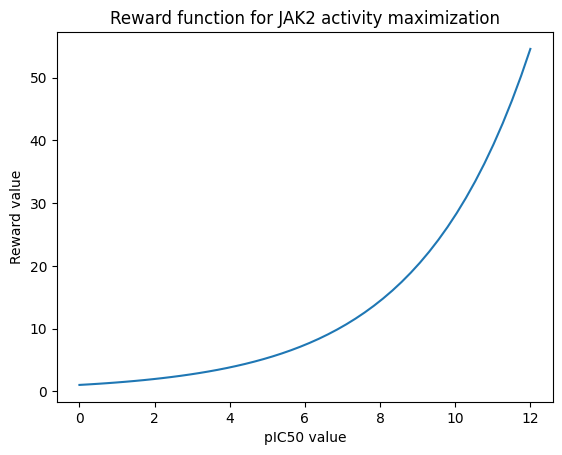

In [34]:
x = np.linspace(0, 12)
y = np.exp(x/3)
plt.plot(x, y)
plt.xlabel('pIC50 value')
plt.ylabel('Reward value')
plt.title('Reward function for JAK2 activity maximization')
plt.show()

In [35]:
RL_max = Reinforcement(my_generator_max, my_predictor, get_reward_max)

rewards_max = []
rl_losses_max = []


In [ ]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward))
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))

    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()

    smiles_cur, prediction_cur = estimate_and_update(RL_max.generator,
                                                     my_predictor,
                                                     n_to_generate,
                                                     get_features=get_fp)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]/home/sl-beast/manikanta/ReLeaSE/release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 10000/10000 [05:37<00:00, 29.61it/s]
[17:50:48] SMILES Parse Error: unclosed ring for input: 'CCCCC1CCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2'
[17:50:48] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCNc2c1c(nc2cc(Cl)cc(Cl)c12)NCCCCCCCNc1c2c(ncn3cc(Cl)cc(Cl)c31)CCCC2'
[17:50:48] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c14)CCC3'
[17:50:48] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCCCCCCNc2c1c(nc2cc(Cl)cc(Cl)c12)CN(C)C3'
[17:50:48] SMILES Parse Error: unclosed ring for input: 'CCC1CCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2'
[17:50:48] SMILES Parse E

Mean value of predictions: 8.58500099384549
Proportion of valid SMILES: 0.0052


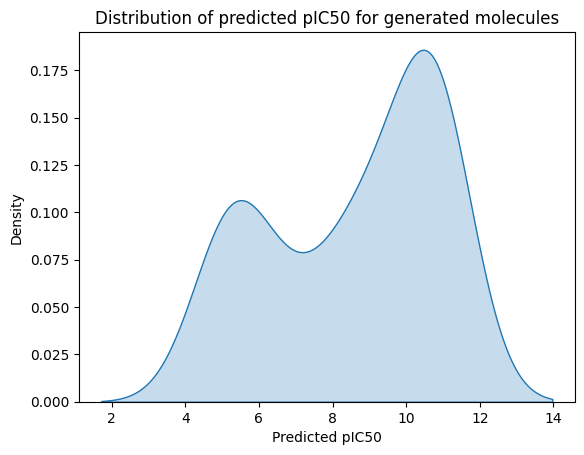

In [38]:
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_max.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

/tmp/ipykernel_115446/2802707189.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prediction_biased_max,label='Maximized', shade=True, color='red')
/tmp/ipykernel_115446/2802707189.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')


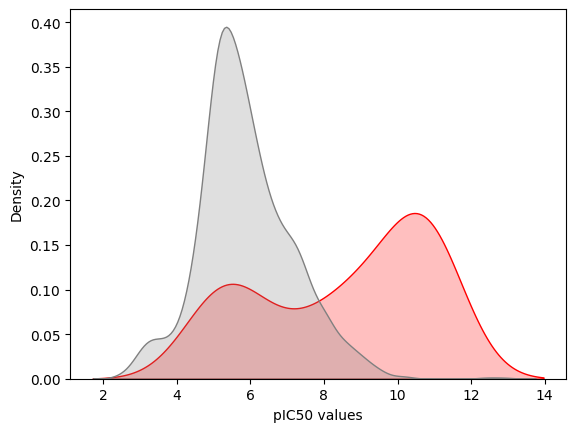

In [39]:
sns.kdeplot(prediction_biased_max,label='Maximized', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('pIC50 values')
plt.show()



In [40]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3



In [41]:
generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_max]
sanitized_gen_mols_max = [generated_mols_max[i] 
                          for i in np.where(np.array(generated_mols_max) != None)[0]]


In [42]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols_max), n_to_draw)
mols_to_draw_max = [sanitized_gen_mols_max[i] for i in ind]
legends = ['pIC50 = ' + str(prediction_biased_max[i]) for i in ind]


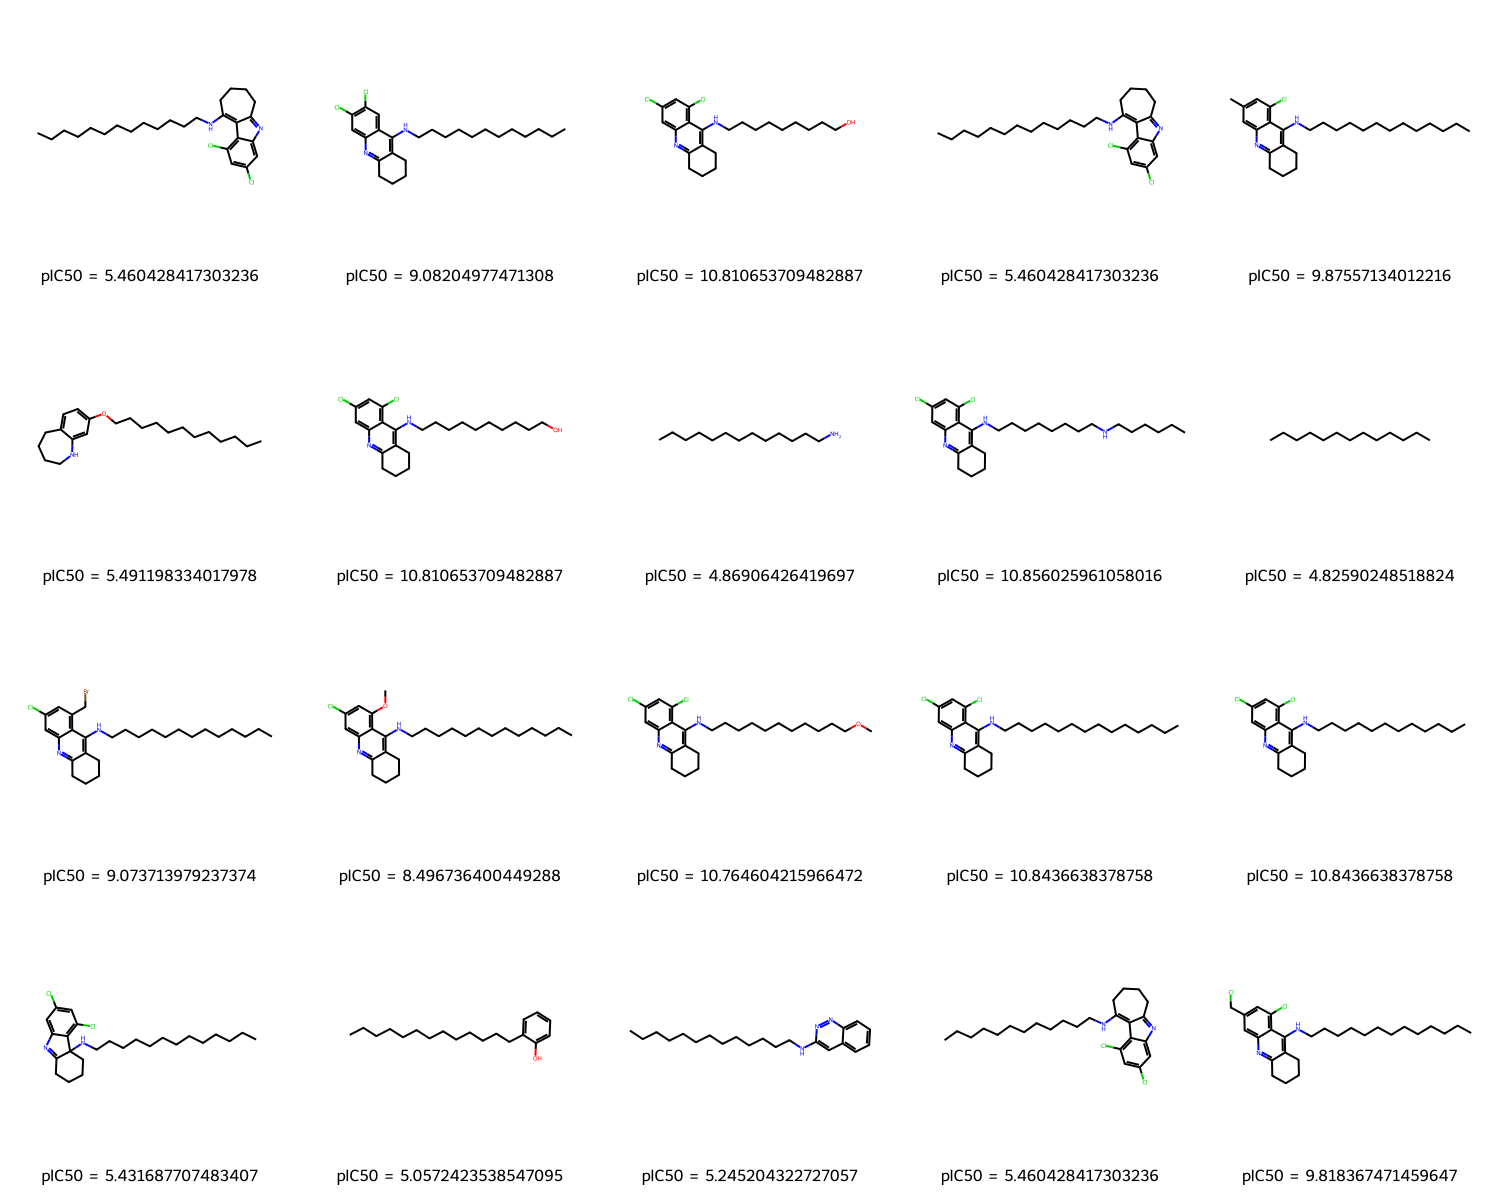

In [43]:

Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

In [46]:
type(RL_max.generator)

stackRNN.StackAugmentedRNN

In [48]:
import pickle

# with open('../../RL_MAX_Gen.pkl','wb') as file:
#     pickle.dump(RL_max.generator,file)

with open('../../RL_MAX.pkl','wb') as file:
    pickle.dump(RL_max,file)

In [50]:
with open('../../RL_MAX_Gen.pkl','rb') as file:
    dummy = pickle.load(file)


smiles_biased_max, prediction_biased_max = estimate_and_update(dummy, 
                                                           my_predictor,
                                                           n_to_generate=10000)

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]/home/sl-beast/manikanta/ReLeaSE/release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
/home/sl-beast/miniconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
Generating molecules...:   7%|▋         | 748/10000 [00:58<12:07, 12.72it/s]


KeyboardInterrupt: 